In [1]:
from src import CompositeDataset
import matplotlib.pyplot as plt
import sys
# print(sys.path)

from graphcast import icosahedral_mesh

In [2]:

omni_dir = "/mnt/ionosphere-data/omniweb/processed/"
# gim_parquet = "/mnt/ionosphere-data/jpld_gim/parquet/jpld_gim_201005130000_202407312345.parquet"
gim_parquet = "/mnt/ionosphere-data/jpld/webdataset"
celestrak_file = "/mnt/ionosphere-data/celestrak/kp_ap_processed_timeseries.csv"
solar_index_file = "/mnt/ionosphere-data/solar_env_tech_indices/Indices_F10_processed.csv"

ds = CompositeDataset(
    dataset_jpld_dir=gim_parquet, 
    celestrak_data_file=celestrak_file, 
    solar_index_data_file=solar_index_file,
    omniweb_dir=omni_dir,
    date_start=None, 
    date_end=None
)


JPLD
Directory  : /mnt/ionosphere-data/jpld/webdataset
Loading tar files index from cache: /mnt/ionosphere-data/jpld/webdataset/tar_files_index
Start date : 2010-05-13 00:00:00
End date   : 2024-07-31 23:45:00
Delta      : 15 minutes
Loading dates from cache: /mnt/ionosphere-data/jpld/webdataset/dates_index_2010-05-13T00:00:00_2024-07-31T23:45:00
TEC maps total    : 498,623
TEC maps available: 498,481
TEC maps dropped  : 142
Celestrak Dataset
Head of data file: 

                           Kp        Ap
Datetime                               
1957-10-01 00:00:00  1.531564  1.012923
1957-10-01 03:00:00  1.317561  0.747159
1957-10-01 06:00:00  0.604218  0.109327
1957-10-01 09:00:00 -0.109126 -0.315895
1957-10-01 12:00:00  1.103558  0.481396

Checking date range of data in file: /mnt/ionosphere-data/celestrak/kp_ap_processed_timeseries.csv
Start date : 1957-10-01 00:00:00
End date   : 2025-08-14 21:00:00
Number of days in dataset   : 24,790
Number of samples in dataset: 198,320
Size on di

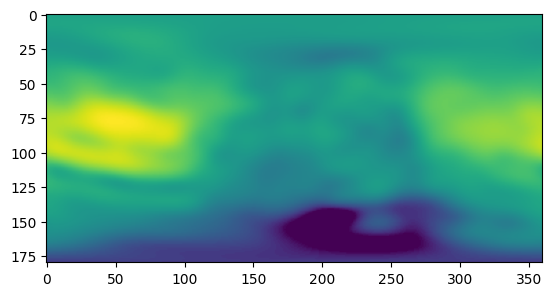

In [3]:
plt.imshow(ds[0]["gim"][0][0]), ds[0]["gim"][0][0].shape
tec_map = ds[0]["gim"][0][0]

In [4]:
import numpy as np

n_lat = 180
n_lon = 360
lat = np.linspace(-90, 90, n_lat)
lon = np.linspace(0, 360, n_lon)


In [5]:
mesh = icosahedral_mesh.get_last_triangular_mesh_for_sphere(splits=5) # adjust splits as needed
# mesh_lat, mesh_lon = lat_lon_deg_to_spherical(mesh.vertices[:,0], mesh.vertices[:,1])


In [6]:
from graphcast import grid_mesh_connectivity
grid_indices, mesh_indices = grid_mesh_connectivity.in_mesh_triangle_indices(grid_latitude = lat, grid_longitude = lon, mesh = mesh)
grid_indices, mesh_indices

(array([    0,     0,     0, ..., 64799, 64799, 64799], shape=(194400,)),
 array([7248, 7249, 7247, ..., 5304, 5305, 5303],
       shape=(194400,), dtype=int32))

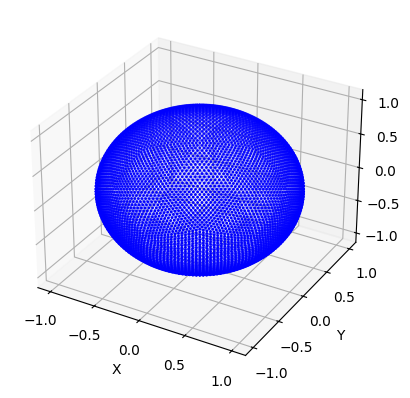

In [7]:
# Create 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Plot the points

ax.scatter(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2], c='blue', s=1)  # 's' controls point size
# ax.scatter(mesh.faces[:, 0], mesh.faces[:, 1], mesh.faces[:, 2], c='blue', s=1)  # 's' controls point size

# Optional: set axis labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Show plot
plt.show()

In [8]:
import numpy as np
unique_grids, counts = np.unique(grid_indices, return_counts=True)
print(np.sum(counts > 1))  # How many grid points appear more than once?


64800


In [9]:
from collections import defaultdict

mapping = defaultdict(list)
for g, m in zip(grid_indices, mesh_indices):
    mapping[g].append(m)

for grid_idx, mesh_list in mapping.items():
    if len(mesh_list) > 1:
        print(f"Grid point {grid_idx} maps to triangles {mesh_list}")
        break


Grid point 0 maps to triangles [np.int32(7248), np.int32(7249), np.int32(7247)]


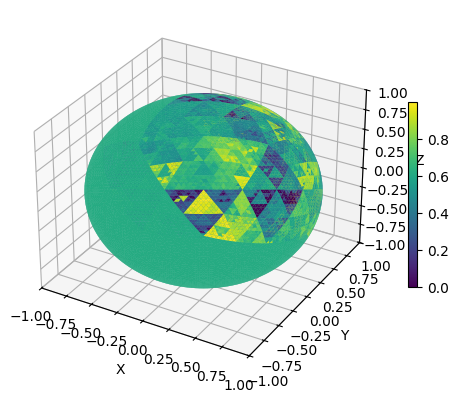

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 1. Prepare triangle vertex coordinates
triangles = mesh.vertices[mesh.faces]  # shape: (num_faces, 3, 3)

# 2. Prepare color per triangle based on grid mapping

# grid_values: a 1D array matching the flattened lat/lon grid
# E.g. grid_values.shape == (N,) where N = num_lat * num_lon
# Get values for the mesh triangles via the mapping
face_colors = np.zeros(len(mesh.faces))  # default value

# Option 1: take average of all grid values mapped to each face
from collections import defaultdict

face_to_values = defaultdict(list)
for g, f in zip(grid_indices, mesh_indices):
    face_to_values[f].append(tec_map.flatten()[g])

for face_idx, values in face_to_values.items():
    face_colors[face_idx] = np.mean(values)

# 3. Normalize for colormap
face_colors_normalized = (face_colors - face_colors.min()) / (np.ptp(face_colors) + 1e-8)

# 4. Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mesh_collection = Poly3DCollection(triangles, array=face_colors_normalized, cmap='viridis')
# mesh_collection.set_edgecolor('k')  # Optional: black edges
ax.add_collection3d(mesh_collection)

# 5. Set axis limits and labels
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.colorbar(mesh_collection, ax=ax, shrink=0.5)
plt.show()
